<a href="https://colab.research.google.com/github/shaikadish/twitterTopicModeling/blob/main/twitterTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Topic Modeling

Topic modeling is an extremely powerful data analysis tool, whereby documents within a larger set are grouped together into sub-sets, based on the information content found within the documents. This unsupervised process automates the grouping of documents, making it a valuable tool in the analysis of large unstructured datasets. 

In our example, we will be applying modern topic modeling techniques to a set of tweets (documents) generated using the *Twitter API* *. This tutorial will explain the steps of this process, and the reasoning behind the various algorithms applied throughout.

The tutorial is broken up into three steps: First, we will extract the tweets from Twitter. Next, we will generate topics from the tweets. Finally, we will process these topics and see what information we can get from them. Lets get started!




**you will need to generate your own bearer token for the API by following [this link](https://developer.twitter.com/en/docs/twitter-api)*


In [ ]:
# Install required libraries
!pip install sentence_transformers
!pip install pysentimiento
!pip install pyyaml==5.4.1
!pip install umap-learn
!pip install hdbscan
!git clone https://github.com/MaartenGr/cTFIDF.git

# Tweet extraction

The first thing we need to do is extract the Tweets from twitter using the *Twitter API*. We will create a set of functions to modularise this process.

In [ ]:
# Imports for tweet extraction
import time
import json
from requests.api import get
from datetime import datetime
import requests
import dateutil.parser as parser
from pysentimiento.preprocessing import preprocess_tweet
import nltk
nltk.download('stopwords')

First we create a set of functions to interface with the *Twitter API*. To better understand the request queries used here, I recommend checking out the [documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction) of the *Twitter API*.

In [5]:
# Use bearer token to access Twitter API
bearer_token = 'YOUR BEARER TOKEN'
headers = {"Authorization": "Bearer {}".format(bearer_token)}

def get_query_params(search_query,start_time,end_time, max_results = 100):

    # Return query for twitter API to request tweets for a given search query
    return {'query': f"{search_query} lang:en -is:retweet",
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}


def request_tweets(search_query,granularity='day', start_time=None, end_time=None, max_count = 50) -> dict:
    
    # URL used in generating requests
    url = "https://api.twitter.com/2/tweets/search/recent"

    # Generate start and end date for tweet requests
    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    # Get request query for specific search query over a given time period
    params = get_query_params('#'+' #'.join(search_query),start_time,end_time)

    # Get requests
    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.extend(response['data'])
    time.sleep(2)
    id_list=[]

    # Parse requests
    while 'next_token' in response['meta'] and len(all_responses) < max_count:
        params['next_token'] = response['meta']['next_token']
        response = requests.request("GET", url, headers=headers, params = params).json()
        
        time.sleep(2)
          
        all_responses.extend(response['data'])

    return all_responses

Next we create a function which makes use of the above functions to extract tweets from twitter. This function takes in the desired `hashtags` we will be searching for, as well as the `period` in days over which we will be looking over. There is also a parameter `tweet_count` which sets the number of tweets requested from Twitter.

In [6]:
def get_tweets(hashtags,period=7,tweet_count=100):
    
    # Get start and end date from period (number of days prior to today over which we are generating tweets)
    today = datetime.now()
    today = today.strftime("%m/%d/%Y") 
    begin_period = today.split('/')
    if int(begin_period[1]) <= period:
        begin_period[0] = str(int(begin_period[0])-1)
        begin_period[1] = str(31-period)
    else:
        begin_period[1] = str(int(begin_period[1])-period)
    begin_period='/'.join(begin_period)

    # Generate and return tweets using hashtags as the search query, over <period> days
    return request_tweets(hashtags,start_time=begin_period,end_time=today,max_count=tweet_count)

The next function we create parses the raw tweet data from the *Twitter API* to extract the text from the tweets. This text is processed within the function to remove undesirable artifacts from the *Twitter API*. [PySentimiento](https://github.com/pysentimiento/pysentimiento) is used to process the raw tweets and output text which is more human-readable.

In [9]:
def get_text(tags,period,tweet_count):

    # Get tweets from twitter
    tweets = get_tweets(tags,period,tweet_count)

    # Process tweet text from tweets
    text = []
    stops = {'emoji','url','@usuario','usuario'}
    for tweet in tweets:
      # Process tweet using pysentimiento
      line_list = preprocess_tweet(tweet['text'],lang = "en",user_token = '',url_token = '').split('\n')
      # Remove source website
      if line_list[0][0] == '[' and line_list[0][-1] == ']':
        line_list = line_list[1:]
      # Remove stop words
      new_text = ' '.join(line_list)
      new_text = ' '.join([word for word in new_text.split(' ') if  not(word in stops)])
      
      text.append(new_text)

    return text

We now make use of `get_text` to extract the tweets. We will extract 1000 tweets with the hashtag *f1* from the last 6 days. I am a big Formula1 fan, and at the time of writing, the Monaco Grand Prix happened yesterday, so there will be a tons of discourse online related to the race. 

In [23]:
# Generate 1000 tweets from the last 6 days using the hashtag 'f1'
text = get_text(['f1'],6,1000)

print(text[109])

Congratulations to Checo for winning the Grand Prix. Disappointing that Lclerc didn't win this, I think Ferrari let him down. Red bull would be pretty happy with that result. monaco gp  f1


Looks good! the text output is human readable, and clearly related to Formula1. Lets proceed! 🏎 🏎 🏎

# Topic Modeling

Now that we have our tweets, we can group them together using topic modeling techniques. 

The approach we are using makes use of [a sentence Transformer Model](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to extract encodings for each tweet. Sentence Transformers have been shown to be more effective than traditional encoding techniques (like LDA) in terms of their preservation of semantic information from the source document, and hense are a good choice for topic modeling. 

We group the sentence encodings using [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html). This clustering algorithm is good for the current task, because it does not require us to set the number of topics (like K-means clustering) and it is able to reject documents from any clusters by labeling them as noise. This is especially useful for our task, because a big problem with tweet data is the vast amounts of spam and automatic posts made by bots found on the site. These posts can be completely unrelated to the search term, placing them far from the main topic cluster within the vector space produced by the Sentence Transformer. HDBSCAN will reject many of these noisy datapoints, idealy leaving us with only clusters containing the desired tweets. 

To represent the topic clusters in vector space, we make use of [UMAP](https://umap-learn.readthedocs.io/en/latest/) for dimensionality reduction. UMAP maintains local structure when reducing the encoding dimensions, making it effective at representing the topic clusters in lower-dimensional space.

In [24]:
# Imports for topic generation
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pandas as pd
import umap
import hdbscan
import torch

This function extracts encodings from a list of tweets using the Sentence Transformer. 

In [11]:
def get_tweet_embedding(text):
    
    # Load encoder model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)

    # Encode tweets
    embedding=[]
    for tweet in text:
        embedding.append(model.encode(tweet))
    embedding = np.array(embedding)
    
    return embedding

Now that we can extract tweet encodings, we can cluster them together using the function bellow. This function calls the HDBSCAN clustering algorithm, and generates the lower-dimensional representation of the tweet-clusters. 



In [25]:
def get_topic_labels(vectors,min_cluster_size):
    
    # Cluster tweet encodings using HDBScan
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(vectors)
    
    # Plot clusters by reducing embeddings to 3D using umap
    fit = umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    reduced_data = fit.fit_transform(vectors)
    result = pd.DataFrame(reduced_data,columns=['x','y','z'])

    # Color each cluster using its unique label
    result['labels'] = cluster.labels_
    clustered = result.loc[result.labels != -1]
    ax = plt.axes(projection = '3d')
    ax.scatter3D(clustered.x,clustered.y,clustered.z,c = clustered.labels)

    return cluster.labels_

The function bellow wraps up all the tweet-clustering functions into one function. This function encodes the input tweets, generates topic labels for them, and returns a pandas DataFrame containing the input tweets labelled by topic.

In [29]:
def get_tweet_label_df(text,min_cluster_size):

  # Generate tweet embeddings
  tweet_embeddings = get_tweet_embedding(text)

  # Generate topics
  labels = get_topic_labels(tweet_embeddings,min_cluster_size)

  # Generate data for DataFrame using tweets and corresponding topic labels
  data = {'tweet':text,'topic':labels}

  return pd.DataFrame(data = data)

With all functions implemented, lets generate some topics!

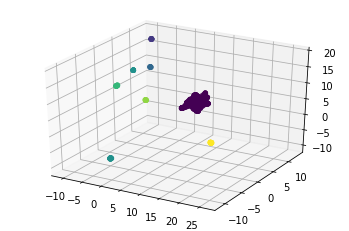

In [30]:
# Generate DataFrame of tweets and topics, with a minumum topic size of 10 tweets
tweets_with_topics = get_tweet_label_df(text,10)

Hmmmm... 🤔

Something doesn't seem quite right here. There are 6 outlying groups! Let's try figure out what is going on with these groups in the section bellow.

# Topic Processing

We now have great functions for extracting tweets and grouping them within topics, but we still need to do some processing of these topics to ensure that we are getting the output that we want, and to analyse the clusters. Remember, topic modeling is an unsupervised tool, so some interpretation and post-processing will always be required in evaluating its outputs.

In [31]:
# Imports for topic processing
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from cTFIDF.ctfidf import CTFIDFVectorizer
from nltk.corpus import stopwords
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import random

Let's take a look at those outliers that we identified above. We will do this by ranking the grouped topics by their sizes (in terms of how many tweets each topic contains), and taking a look at the small outlying groups.



In [43]:
# Generate list of topics ranked by topic size
ranked_topics = tweets_with_topics.topic.value_counts().index.to_list()

tweets_with_topics[tweets_with_topics.topic == ranked_topics[-1]].head()

,tweet,topic
213,Steve Harvey hate WHITES-rob BLACKS. Uses GOD ...,2
215,Steve Harvey hate WHITES-rob BLACKS. Uses GOD ...,2
216,Steve Harvey hate WHITES-rob BLACKS. Uses GOD ...,2
217,Steve Harvey hate WHITES-rob BLACKS. Uses GOD ...,2
218,Steve Harvey hate WHITES-rob BLACKS. Uses GOD ...,2


Okay... it may just be me, but I do not see what Steve Harvey hating white people has to do with Formula1. 

This is clearly an example of the spam posting I mentioned earlier. In some cases, there are enough spam posts on a specific topic for those posts to be identified as their own unique topic, rather than noisy outliers.

Luckily, the largest cluster contains the vast majority of the tweets, and this cluster actually relates to Formula1. This large cluster emerges because the outliers are so far apart that all topics related to Formula1 are grouped as a single large topic. This is actually very useful for us, because all we need to do is take the tweets from this large topic, and then find sub-topics within it! This is effectively a very simple and easy way to remove noise from our document set.

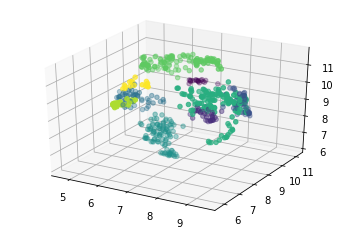

In [56]:
# Get topic number of topic containing the most tweets
biggest_topic = ranked_topics[0]

# Generate new tweets with topics using the biggest topic from the original clustering
new_text = tweets_with_topics.tweet[tweets_with_topics.topic == biggest_topic].to_list()
new_tweets_with_topics = get_tweet_label_df(new_text,15)

That seemed to work! We have now generated a set of topics which seem to be close enough together in vector space to be related to the same larger topic. 

We will now write some functions to interpret the information derived from these groupings. The first thing we will do is write a function to extract the most used words for each topic, using [c-TF-IDF](https://github.com/MaartenGr/cTFIDF.git). This is a simple frequency-based method used to extract the most used terms within a corpus related to each topic:

In [131]:
def get_top_topic_words(tweets_with_topics,n_words=5):

  # Generate a corpus for each topic
  docs_per_class = tweets_with_topics.groupby(['topic'],as_index=False).agg({"tweet":' '.join})

  for doc in docs_per_class.iterrows():

    doc = doc[1]
    new_corpus = []

    # Remove stop words from each corpus
    for word in doc.tweet.split(' '):
      if not(word.lower() in stopwords.words('english')):
        new_corpus.append(word)
    docs_per_class.tweet.loc[docs_per_class.topic == doc.topic] = ' '.join(new_corpus)

  # Create c-TF-IDF
  count_vectorizer = CountVectorizer().fit(docs_per_class.tweet)
  count=count_vectorizer.transform(docs_per_class.tweet)
  words=count_vectorizer.get_feature_names()

  ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples = len(tweets_with_topics)).toarray()

  # Generate top words dictionary
  top_words = {str(topic): [words[index] for index in ctfidf[topic+1].argsort()[-n_words:]] for topic in docs_per_class.topic}

  return top_words

Another revealing piece of information we can extract for each topic is the general sentiment of tweets found within that topic. For this task, we will use a [RoBERTa model](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis), pretrained specifically for tweet sentiment analysis.

In [46]:
def get_sentiment(tweets,n_sentiments):
    
    # Load tokenizer and model for sentiment analysis
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis",)
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis").to(device)
    
    # Generate average sentiment across n_sentiments tweets
    outputs_list = []
    for i in range(n_sentiments):
      # Generate sentiment for a single tweet
      inputs = tokenizer(tweets[i],return_tensors = 'pt',truncation = True)
      outputs = model(**inputs.to(device)) 
      outputs_list.append([i.item() for i in outputs.logits[0]])

    # Generate and return average sentiment 
    return np.array(outputs_list).mean(axis=0)

We can wrap up the above information-extraction functions into one function which outputs a DataFrame representing the information derived for each topic from the input DataFrame of tweets and their corresponding topics:

In [156]:
def get_topic_info(tweets_with_topics):

  # Create data dictionary for topic information
  data = {'topic':[],'top_words':[],'POS':[],'NEG':[],'NEU':[],'tweet_count':[]}

  # Generate the top 10 words for each topic using c-TF-IDF
  top_words = get_top_topic_words(tweets_with_topics,n_words = 10)

  # Generate information for each topic
  for topic in tweets_with_topics.topic.unique():

    # Skip unclustered tweets topic
    if topic == -1:
      continue

    # Generate average sentiment for 10 tweets from current topic
    class_tweets = tweets_with_topics.tweet[tweets_with_topics['topic'] == topic].to_list()
    sentiment = get_sentiment(class_tweets,10)

    # Append topic information
    data['topic'].append(topic)
    data['top_words'].append(top_words[str(topic)])
    data['POS'].append(sentiment[2])
    data['NEG'].append(sentiment[0])
    data['NEU'].append(sentiment[1])
    data['tweet_count'].append(len(class_tweets))
    
  return pd.DataFrame(data = data)

And one more function to explore the topic information for each topic, as well as print out some example tweets for that topic:

In [157]:
def get_topic_example(tweets_with_topics,topic_info,topic_number):

  # Get topic info for topic <topic_number>
  info = topic_info[topic_info.topic == topic_number]

  # Get tweets for topic <topic_number>
  tweets = new_tweets_with_topics[new_tweets_with_topics.topic == topic_number].tweet

  # Find maximum sentiment for topic
  sentiments = [info.POS,info.NEG,info.NEU]
  sentiment = np.argmax(sentiments)
  if sentiment == 0:
    sentiment='Positive'
  elif sentiment == 1:
    sentiment = 'Negative'
  else:
    sentiment = 'Neutral'

  # Print information and tweet examples for topic
  print('---Topic Info---')
  print(f'Number of tweets: {info.tweet_count.item()}')
  print("Sentiment: "+sentiment)
  print(f'Top words: {info.top_words.item()}')
  print('\n---Example tweets---')
  for i,tweet in enumerate(random.choices(tweets.to_list(),k = 5)):
    print(str(i+1)+'. '+tweet)



Let's get the topic info!

In [170]:
# Generate information for each topic
topic_info = get_topic_info(new_tweets_with_topics)

topic_info

,topic,top_words,POS,NEG,NEU,tweet_count
0,6,"[f1, sports, formula1, race, racing, grand, pr...",0.843529,-3.386930,2.301096,123
1,3,"[light, even, thumbs, boring, calendar, cars, ...",-1.233609,0.157484,1.075400,53
2,2,"[speaking, daniel, happen, gp, tough, home, fe...",-1.009525,-0.810130,1.746507,45
3,5,"[grand, prix, red, monaco, gp, win, sergio, ve...",1.557194,-2.740254,1.028896,138
4,4,"[yellow, bull, red, new, one, notes, rule, rul...",-2.028589,1.142650,0.928538,98
5,0,"[joy, rolling, tears, 2022, drivers, floor, la...",-0.055291,-1.831694,1.750429,17
6,1,"[want, wolff, race, news, points, didnt, ocon,...",-1.778916,0.817932,1.004478,38
7,7,"[former, second, swede, driver, win, indy, 500...",1.779052,-2.894461,0.956459,31
8,8,"[match, cola600, check, coca, indycar, motorsp...",1.247729,-3.050112,1.596168,17


Looks good. Now we can use `get_topic_example` to further examine the top three largest topics and evaluate their content:

In [161]:
get_topic_example(new_tweets_with_topics,topic_info,4)

---Topic Info---
Number of tweets: 98
Sentiment: Negative
Top words: ['yellow', 'bull', 'red', 'new', 'one', 'notes', 'rule', 'rules', 'line', 'fia']

---Example tweets---
1. Why are the Abu Dhabi stewards still f1 stewards?  ?
2. I wonder if those Ferrari fans who were a bit on the fence after AD farce are beginning to realise that fia's loose handling of the rules may after all affect more than just one team? f1 monaco gp
3. Does  have the right holding up charles leclerc like that!? Isnt he supposed to let him through immediately!?  monaco gp f1
4. How long is it going to take  to realise that every racing issue they have is a result of the  ballsing it up, either accidentally or intentionally ($$$) and destroying the integrity of f1? Im sick of this bullshit.  unamused face
5. The incompetence of the  and their rule makers just amazes me week after week. f1 needs a breakaway from the FIA and run the sport themselves, properly, with concrete rules.


Of course this is a big one. Are you really a Formula1 fan if you don't complain about rulings made by the FIA and bad calls from the stewards? This topic appears to be outraged fans complaining about the many dicey calls made by officials at yesterday's Grand Prix. The sentiment was appropriately identified as negative, and among the top words, revealing words include *rule, rules, fia,* and *line*. 

I am not sure if `bull` refers to Red Bull Racing or something else...

In [165]:
get_topic_example(new_tweets_with_topics,topic_info,6)

---Topic Info---
Number of tweets: 123
Sentiment: Neutral
Top words: ['f1', 'sports', 'formula1', 'race', 'racing', 'grand', 'prix', 'monaco', '2022', 'gp']

---Example tweets---
1. What a monaco gp this was! Epic rain first half and a  train for the 2nd. Listen in (links in comments) as  guests on 100 seconds. But did Pit Lane Paul  bring the incredible  of  to open his segment? dirtyside f1
2. Surpsingly interesting race at Monaco. Lots of overtakes, strategy drama, Red flags, penalties. 2022 is turning out to be one of the best seasons in modern F1 era. f1 monaco gp
3. 2022 Monaco Grand Prix Review -   In this video, I give you my thoughts about the 2022 Monaco Grand Prix Review.   monaco grand prix monaco gp f1
4. OFFICIAL f1 Report: Haas F1 - Monaco GP Race  f1 f1 reports monaco gp
5. F1 2021 SimRacing my favorite picture  f1 sim racing formula1 codemasters alpine russia russiagp bestpicture


This topic appears to be general news reports related to yesterdays Grand Prix. The keywords are very revealing in their generality, and the neutral sentiment likely arrises from the non-biased style of many headlines being reported. 

In [169]:
get_topic_example(new_tweets_with_topics,topic_info,5)

---Topic Info---
Number of tweets: 138
Sentiment: Positive
Top words: ['grand', 'prix', 'red', 'monaco', 'gp', 'win', 'sergio', 'verstappen', 'checo', 'perez']

---Example tweets---
1. Another weekend, another where George betters  on Saturday and Sunday.  is out performing a seven-time world champion, and he isnt getting the plaudits he should be.  Great job, George!  clapping hands light skin tone   monaco gp f1
2. Great to see  keeping up with the now  win tradition started by  &amp; Sebastian Vettel in 2010... f1 monaco gp
3. f1  Mexico    WINS IN MONACO!!!   The Mexican takes the chequered flag after an extraordinary race, Sainz finishes second, Verstappen third  monaco gp f1
4. Another weekend, another where George betters  on Saturday and Sunday.  is out performing a seven-time world champion, and he isnt getting the plaudits he should be.  Great job, George!  clapping hands light skin tone   monaco gp f1
5. Away from his mistake-littered start at Red Bull, Sergio Perez is witho

Finally some good news! Checo wins his first Monaco Grand Prix! The online community seems elated for him, and everyone is talking about it. When you look more into this topic, it actually represents generally congratulatory remarks for any driver (notice the tweets congratulating George on his great performance). This topic clearly has a positive sentiment, and the most used words for the topic include *win, sergio, perez* and *checo*, all of these words reffering to the winner of the race.

After looking at these topics, I think that our exercise in topic modeling was largely succesful, with these topics being clear and relatively consistent across the tweets contained within them. I think that the performance of the various algorithms used could be improved through the use of more precise pre-processing of the tweets, but our approach seems to have worked well enough for this tutorial.

I sincerely hope that you come away from this with a better understanding of topic modeling, and with some more tools in your belt for tackling NLP problems!